# NEU502b Analysis: Signal Corruption

In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv, concat
from scripts.utilities import read_gifti
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define metadata.
func_dir = 'preproc/fmriprep'
subjects = ['sub-01','sub-02']
tasks = ['visualcontrol', 'visualbreathhold', 'visualhyperventilate']
spaces = ['fsaverage5.L','fsaverage5.R']

/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Step 1: Generate Task Regressors

In [2]:
from scripts.spm_hrf import spm_hrf

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Task metadata.
n_acq = [250, 370, 370]
tr = 1

## Define upsampling level.
sfreq = 100

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Generate HRF.
hrf = spm_hrf(1/sfreq)

for subj in subjects:
    
    for task, T in zip(tasks, n_acq):
    
         ## Prepare save-directory.
        out_dir = os.path.join('first_levels', task)
        if not os.path.isdir(out_dir): os.makedirs(out_dir)
    
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Load and prepare events.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

        ## Load events file.
        f = os.path.join('raw', subj, 'func', '%s_task-%s_events.tsv' %(subj,task))
        events = read_csv(f, sep='\t')

        ## Drop fixation cross.
        events = events[events.event == 'Checkerboard']

        ## Round onset times.
        events['onset'] = events['onset'].round(int(np.log10(sfreq)))

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Generate task regressors.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

        ## Define TR onsets.
        tr_onsets = np.arange(0, T, tr)
        
        ## Initialize boxcars.
        times = np.linspace(0, T + 1/sfreq, T * sfreq).round(int(np.log10(sfreq)))
        boxcars = np.zeros_like(times)

        ## Generate boxcars.
        for onset, duration in events[['onset','duration']].values:
            ix = np.logical_and(times >= onset, times <= onset + duration)
            boxcars[ix] += 1

        ## Generate estimated hemodynamic response.
        hemo = np.convolve(boxcars, hrf)[:times.size]

        ## Downsample regressors.
        boxcars = boxcars[np.in1d(times, tr_onsets)]
        hemo = hemo[np.in1d(times, tr_onsets)]
        times = times[np.in1d(times, tr_onsets)]

        ## Scale estimated hemodynamic response.
        hemo /= hemo.max()
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Save task regressors.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

        ## Save.
        f = os.path.join(out_dir, '%s_task-%s_events.txt' %(subj, task))
        np.savetxt(f, hemo)
    
print('Done.')

Done.


### Visualize example

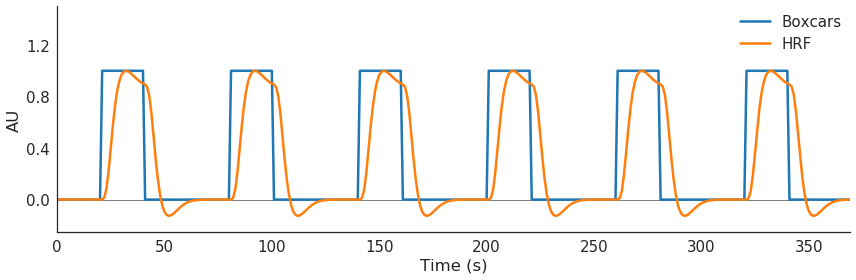

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot.
ax.plot(times, boxcars, lw=2.5, label='Boxcars')
ax.plot(times, hemo, lw=2.5, label='HRF')

## Add info.
ax.hlines(0,0,times.max(),lw=0.5,zorder=0)
ax.set(xlim=(0,times.max()), xlabel='Time (s)', ylim=(-0.25,1.5), 
       yticks=np.arange(0,1.3,0.4), ylabel='AU')
ax.legend(loc=1, borderpad=0)

sns.despine()
plt.tight_layout()

## Step 2: First Level Analysis

In [4]:
from scripts.prewhitening import prewhiten_data
from scripts.permutations import permutation_testing
from scripts.utilities import mask_insert
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Analysis parameters.
n_perm = False 

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for task in tasks:
    
    ## Prepare save-directory.
    out_dir = os.path.join('first_levels', task)
    if not os.path.isdir(out_dir): os.makedirs(out_dir)
    
    for subj in subjects:

        for space in spaces:

            if not n_perm: break

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### Load and prepare data.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

            ## Load task regressors.
            f = os.path.join('first_levels',task,'%s_task-%s_events.txt' %(subj,task))
            events = np.loadtxt(f)
            if events.ndim == 1: events = events.reshape(-1,1)
            _, n_task = events.shape

            ## Load motion regressors.
            f = os.path.join('first_levels',task,'%s_task-%s_motion.txt' %(subj,task))
            motion = np.loadtxt(f)
            if motion.ndim == 1: motion = motion.reshape(-1,1)
                
            ## Load task data.
            f = os.path.join('first_levels',task,'%s_task-%s_space-%s.psc.npz' %(subj,task,space))
            npz = np.load(f)

            ## Remove null vertices. 
            data, mask = npz['psc'], npz['mask']
            Y = data[:,mask]

            ## Append intercept to nuisance regressors.
            nuisance = np.concatenate([np.ones([motion.shape[0], 1]), motion], axis=-1)            
            
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### Prewhiten data.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

            ## Construct design matrix.
            X = np.concatenate([events, nuisance], axis=-1)

            ## Prewhiten data (see script for details).
            WY, WX = prewhiten_data(Y, X)

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### First-level regression.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

            ## Permutation testing (see script for details.)
            B, F, p = permutation_testing(WY, WX, n_task, n_perm)

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### Save results.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

            ## Save.
            f = os.path.join(out_dir, '%s_task-%s_space-%s.ces.npz' %(subj, task, space))
            np.savez_compressed(f, B=mask_insert(B,mask), F=mask_insert(F,mask), 
                                p=mask_insert(p,mask))

print('Done.')

Done.


### Generate Surface Maps

In [5]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Significance threshold.
alpha = 0.05

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Redefine threshold.
threshold = -np.log10(alpha)

for task in tasks:

    ## Define save-directory.
    out_dir = os.path.join('first_levels', task)
    
    for subj in subjects:

        for space in spaces:

            ## Load data.
            f = os.path.join(out_dir, '%s_task-%s_space-%s.ces.npz' %(subj, task, space))
            npz = np.load(f)

            ## Extract PSC and p-vals corresponding to checkerboard condition.
            psc, pvals = npz['B'][0], npz['p'][0]

            ## Threshold PSC by significance.
            psc[np.abs(pvals) < threshold] = 0

            ## Convert to NIFTI image.
            obj = nib.Nifti1Image(psc.reshape(-1,1,1,1), np.identity(4))

            ## Save.
            f = os.path.join(out_dir, '%s_task-%s_space-%s.psc.nii.gz' %(subj, task, space))
            nib.save(obj, f)

## Step 3: Effects of Corruption

### Visualize PSC in Visual Localizer

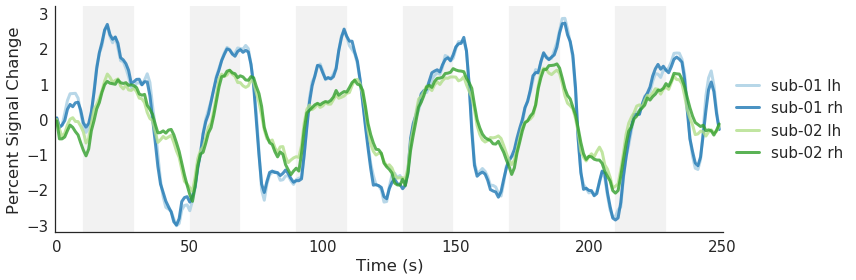

In [6]:
from mne import read_label

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

task = 'visualcontrol'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define paths.
data_dir = 'first_levels/%s' %task
label_dir = 'first_levels/labels'

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))
colors = sns.color_palette("Paired", n_colors=4).as_hex()
colors = np.array(colors).reshape(2,2)

for i, subj in enumerate(subjects):
    
    for j, space in enumerate(spaces):
        
        ## Load data.
        f = os.path.join(data_dir, '%s_task-%s_space-%s.psc.npz' %(subj, task, space))
        data = np.load(f)['psc']
        
        ## Load contrast.
        f = os.path.join(data_dir, '%s_task-%s_space-%s.psc.nii.gz' %(subj, task, space))
        psc = nib.load(f).get_data()
        
        ## Load label.
        hemi = 'lh' if space == 'fsaverage5.L' else 'rh'
        f = os.path.join(label_dir, '%s_V1-%s.label' %(subj, hemi))
        label = read_label(f)
        
        ## Mask data by label.
        data = data[:,label.vertices].mean(axis=-1)
        psc = psc[label.vertices]
        
        ## Plot.
        ax.plot(data, lw=3, label='%s %s' %(subj, hemi), color=colors[i,j], alpha=0.8)
        
## Add info.
for tmin, tmax in zip(np.arange(10,250,40), np.arange(30,250,40)):
    ax.fill_between(np.arange(tmin,tmax), -3.2, 3.2, color='0.95')
ax.set(xlim=(-0.5, 250.5), xlabel='Time (s)', ylim=(-3.2,3.2), 
       ylabel='Percent Signal Change')
ax.legend(loc=7, bbox_to_anchor=(1.2,0.5), handlelength=1.5)

## Save figure.
sns.despine()
plt.tight_layout()
plt.savefig('plots/fig1/V1_psc.png', dpi=180)

### Contrast PSC across conditions

/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/media/szoro/SZORO1/pni-courses/neu502b/fmri/scripts/prewhitening.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  B_ols, _, _, _ = np.linalg.lstsq(X, Y)


sub-01 visualcontrol fsaverage5.L 3.11 (0.33)
sub-01 visualcontrol fsaverage5.R 3.13 (0.35)
sub-01 visualbreathhold fsaverage5.L 3.13 (0.38)
sub-01 visualbreathhold fsaverage5.R 2.98 (0.36)
sub-01 visualhyperventilate fsaverage5.L 1.53 (0.17)
sub-01 visualhyperventilate fsaverage5.R 1.41 (0.16)
sub-01 Con vs. Breath: 0.04 (0.848)
sub-01 Con vs. Hyper: 38.19 (0.000)
sub-02 visualcontrol fsaverage5.L 1.67 (0.27)
sub-02 visualcontrol fsaverage5.R 1.70 (0.23)
sub-02 visualbreathhold fsaverage5.L 0.54 (0.23)
sub-02 visualbreathhold fsaverage5.R 0.41 (0.24)
sub-02 visualhyperventilate fsaverage5.L 0.44 (0.14)
sub-02 visualhyperventilate fsaverage5.R 1.05 (0.14)
sub-02 Con vs. Breath: 24.45 (0.000)
sub-02 Con vs. Hyper: 20.94 (0.000)


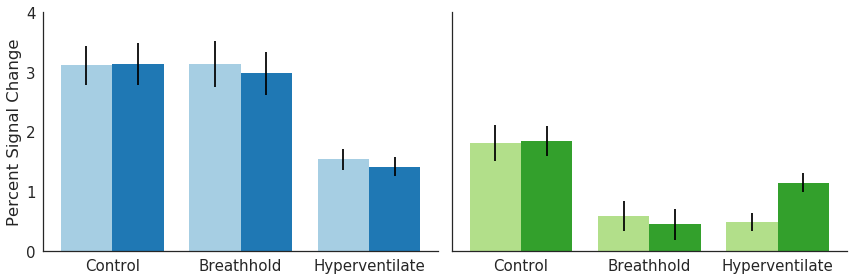

In [7]:
from scipy.linalg import block_diag
from statsmodels.api import OLS

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4),sharex=True,sharey=True)
palette = sns.color_palette("Paired", n_colors=4).as_hex()
palette = np.array(palette).reshape(2,2)

for ax, subj, colors in zip(axes, subjects, palette):
    
    WX, WY = [], []
    
    for task in tasks:
        
        ## Prepare save-directory.
        out_dir = os.path.join('first_levels', task)
        if not os.path.isdir(out_dir): os.makedirs(out_dir)

        for space in spaces:

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### Load and prepare data.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

            ## Load task regressors.
            f = os.path.join('first_levels',task,'%s_task-%s_events.txt' %(subj,task))
            events = np.loadtxt(f)
            if events.ndim == 1: events = events.reshape(-1,1)
            _, n_task = events.shape

            ## Load motion regressors.
            f = os.path.join('first_levels',task,'%s_task-%s_motion.txt' %(subj,task))
            motion = np.loadtxt(f)
            if motion.ndim == 1: motion = motion.reshape(-1,1)
                
            ## Load task data.
            f = os.path.join('first_levels',task,'%s_task-%s_space-%s.psc.npz' %(subj,task,space))
            npz = np.load(f)

            ## Load label.
            hemi = 'lh' if space == 'fsaverage5.L' else 'rh'
            f = os.path.join(label_dir, '%s_V1-%s.label' %(subj, hemi))
            label = read_label(f)

            ## Mask data by label.
            y = npz['psc'][:,label.vertices].mean(axis=-1).reshape(-1,1)

            ## Append intercept to nuisance regressors.
            nuisance = np.concatenate([np.ones([motion.shape[0], 1]), motion], axis=-1)            
            
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### Prewhiten data.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

            ## Construct design matrix.
            X = np.concatenate([events, nuisance], axis=-1)

            ## Prewhiten data (see script for details).
            wy, wX = prewhiten_data(y, X)
            wX, wy = wX.squeeze(), wy.squeeze()
            
            ## Append.
            WX.append(wX)
            WY.append(wy)
                        
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### First level regression.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Identify checkerboard contrast.
    indices = np.insert(np.cumsum([wx.shape[-1] for wx in WX])[:-1], 0, 0)

    ## Perform OLS.
    WX = block_diag(*WX)
    WY = np.concatenate(WY)
    fit = OLS(WY, WX).fit()
    
    ## Iteratively print info.
    b = fit.params[indices].reshape(3,2)
    t = fit.tvalues[indices].reshape(3,2)
    for i, task in enumerate(tasks):
        for j, space in enumerate(spaces):
            print('%s %s %s %0.2f (%0.2f)' %(subj,task,space,b[i,j],(b/t)[i,j]))

    ## Perform contrasts (Control vs. Breathhold).
    contrast = [1,1,-1,-1,0,0]
    r_matrix = np.zeros_like(fit.params)
    r_matrix[indices] = contrast
    f_test = fit.f_test(r_matrix)
    print('%s Con vs. Breath: %0.2f (%0.3f)' %(subj, f_test.fvalue, f_test.pvalue))

    ## Perform contrasts (Control vs. Hyperventilate).
    contrast = [1,1,0,0,-1,-1]
    r_matrix = np.zeros_like(fit.params)
    r_matrix[indices] = contrast
    f_test = fit.f_test(r_matrix)
    print('%s Con vs. Hyper: %0.2f (%0.3f)' %(subj, f_test.fvalue, f_test.pvalue))
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plotting.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Barplots.
    x = [0,1,2.5,3.5,5,6]
    y = fit.params[indices]
    yerr = (fit.params / fit.tvalues)[indices]
    ax.bar(x, y, width=1, yerr=yerr, color=colors)
    ax.set(xticks=[0.5,3,5.5], xticklabels=['Control','Breathhold','Hyperventilate'])
    
## Add info to plot.
axes[0].set(yticks=np.arange(5), ylabel='Percent Signal Change')
    
sns.despine()
plt.tight_layout()